# Pre-workout

## Preface and import

In [ ]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from PIL import Image
import imghdr
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.python.keras.utils.data_utils import Sequence

import utils

target_shape = (128, 128)


## Data

In [ ]:

#clean_dataset('/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/')

## Model

In [5]:
# feature extraction
def create_embedding():
  # Create the base pre-trained model
  inputs = tf.keras.Input(shape=target_shape + (3,))
  rescaling = layers.Rescaling(1./255)(inputs)
  norm = tf.keras.layers.Normalization( mean = [0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225])(rescaling) 
  base_cnn = resnet.ResNet50( weights="imagenet", include_top=False )(norm)
  pooling=  layers.GlobalAveragePooling2D()(base_cnn)
  output = layers.Flatten()(pooling)
  
  embedding = Model(inputs, output, name="Embedding")
    

  return embedding

In [7]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [8]:
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1) # distance between anchor and positive
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [9]:
# we can use different embeddings like the resnet50-based or the vgg
def create_siamese(embedding):
    
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], 
        outputs=distances
    )

    return siamese_network

# Model

## Dataset

In [ ]:
import utils

training_path = '/datasets/animali/unbalanced_dataset_2304 2/training/'
validation_path = '/datasets/animali/unbalanced_dataset_2304 2/validation/gallery/'

training_generator = utils.DataGenerator(training_path, batch_size = 128)
validation_generator = utils.DataGenerator(validation_path, batch_size = 128)


## Define siamese model

In [ ]:
embedding = create_embedding()
siamese_network = create_siamese(embedding)
siamese_model = SiameseModel(siamese_network)

## Train model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/triplet50/cp.ckpt"
checkpoint_dir = os.path.dirname("/content/drive/MyDrive/checkpoints/triplet50/cp.ckpt")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

siamese_model.compile(optimizer=optimizers.Adam(0.0001))
#siamese_model.compile(optimizer = optimizers.SGD(learning_rate=1e-3))

siamese_model.fit(training_generator, validation_data = validation_generator, epochs=100)

## Load Model

In [ ]:

checkpoint_path = "/content/drive/MyDrive/checkpoints/triplet50/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

siamese_model = SiameseModel(siamese_network)
siamese_model.load_weights(latest)



# Evaluate

## Test dataset

In [12]:
import utils
gallery_path = '/datasets/animali/unbalanced_dataset_2304 2/validation/gallery/'
query_path = '/datasets/animali/unbalanced_dataset_2304 2/validation/query/'


gallery_ds = utils.DataGenerator(gallery_path, batch_size = 64)
query_ds = utils.DataGenerator(query_path, batch_size = 64)

gallery = gallery_ds.get_dataset()
query = query_ds.get_dataset()







init generator
Loaded 120 images from /datasets/animali/unbalanced_dataset_2304 2/validation/gallery/ 
init generator
Loaded 33 images from /datasets/animali/unbalanced_dataset_2304 2/validation/query/ 


## get results

 embeddings 

In [15]:
gallery_features, gallery_urls, gallery_labels = utils.compute_features(gallery, embedding)
query_features, query_urls, query_labels = utils.compute_features(query, embedding)
results = utils.compute_results(query_features, gallery_features, query_urls, gallery_urls)

33


## evaluate topk

this can be used with labeled data to evaluate the topk

In [17]:
topk, err = utils.evaluate(results, query_labels, gallery_labels)
topk

{1: 0.15, 3: 0.27, 5: 0.3, 10: 0.45, 11: 0.55}

## display images

In [ ]:
it = iter(err) # iterate over all the queries that are not in top 10

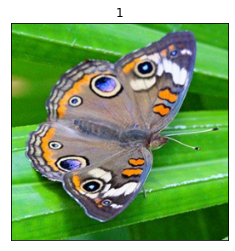

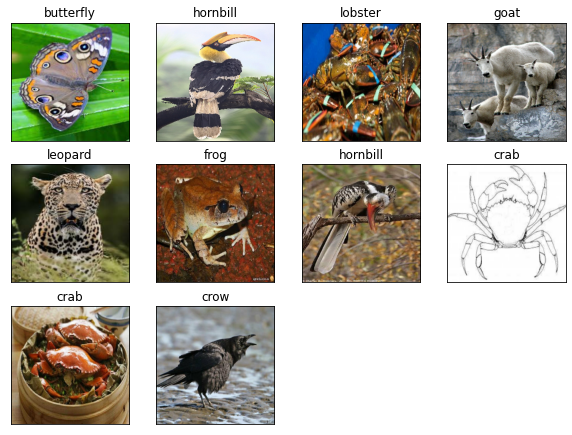

In [ ]:
query_item = next(it)
utils.display_results(query_item, results, query_labels, gallery_labels, target_shape)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>